In [1]:
#Implementing the housing regression from Chapter 3.6 in Deep Learning with Python

#Importing the necessary libraries
from keras.datasets import boston_housing
import numpy as np
from keras import models
from keras import layers
import matplotlib.pyplot as plt

In [2]:
#Importing and splitting the data into training and testing data
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

#Viewing the shape of the data
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [3]:
#Normalizing the data by subtracting the mean from each point and dividing by the standard deviation
#This ensures that the data range stays small
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [4]:
#Building the model within a function so that it can be called multiple times
def build_model():
    #Defining the layers
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    
    #Compiling the model and passing the optimizer, loss function, and required metrics into it
    #The metric used for regression will be MAE (mean average error)
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

In [5]:
#Conducting a k-fold validation since the sample size is very small

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i+1)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]], 
                                         axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                            train_targets[(i + 1) * num_val_samples:]], 
                                           axis=0)
    model = build_model()

    model.fit(partial_train_data, partial_train_targets, 
              epochs = num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0) 
                                                              
    all_scores.append(val_mae)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [6]:
#Viewing the scores for each step and the average score
print(all_scores)
print(np.mean(all_scores))

[1.9101117849349976, 2.869312047958374, 2.713383674621582, 2.905144453048706]
2.599487990140915


In [7]:
#Rerunning the k-fold validation with 500 epochs and a validation score log saved for each epoch
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i+1)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                         train_data[(i + 1) * num_val_samples:]], 
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                            train_targets[(i + 1) * num_val_samples:]], 
                                           axis=0)
    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data = (val_data, val_targets), 
                        epochs = num_epochs, batch_size = 1, verbose = 0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [8]:
#Finding the average of the k-fold validation MAE scores for each epoch
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

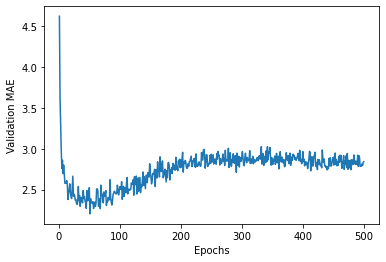

In [9]:
#Plotting the k-fold validation MAE for each epoch

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

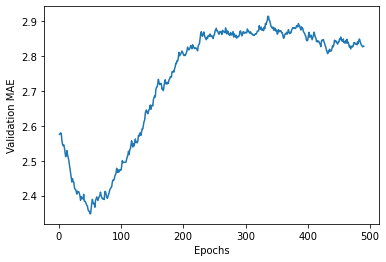

In [10]:
#Plotting the k-fold validation MAE for each epoch excluding the first 10 epochs
#This time, the points will be smoothed with a moving average

#Defining the smoothing function
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 -
factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

#Applying the smoothing function to the points excluding the first 10
smooth_mae_history = smooth_curve(average_mae_history[10:])

#Plotting the smoothed validation MAE over the epochs excluding the first 10
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
#It looks like MAE stops decreasing around 75-80 epochs

In [11]:
#Training the final model on the data using 80 epochs (epoch number with the lowest MAE)

model = build_model()
model.fit(train_data, train_targets, epochs = 80, batch_size = 16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 17.5505 - mae: 2.5882


In [12]:
#Displaying the final MAE score
test_mae_score

2.5882184505462646